In [89]:
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from keras.callbacks import LambdaCallback

In [21]:
df = pd.read_csv('PokeDataset.csv')

In [22]:
df = df[['Name', 'Type1', 'Type2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

In [23]:
df.head()

,Name,Type1,Type2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,60,62,63,80,80,60
2,Venusaur,Grass,Poison,80,82,83,100,100,80
3,Charmander,Fire,NaN,39,52,43,60,50,65
4,Charmeleon,Fire,NaN,58,64,58,80,65,80


In [78]:
names = df['Name'].values
print(names[:5])

['Bulbasaur' 'Ivysaur' 'Venusaur' 'Charmander' 'Charmeleon']


In [79]:
names_duplicates = list(map(lambda s: s.split('-')[0], names))
names = list(set(names_duplicates))
names = list(map(lambda s: s + '.', names))
names = list(map(lambda s: s.lower(), names))
# remove '
names = list(map(lambda s: s.replace("'", ''), names))
# remove numbers
names = list(map(lambda s: ''.join([i for i in s if not i.isdigit()]), names))
# remove :
names = list(map(lambda s: s.replace(":", ''), names))
# change é to e
names = list(map(lambda s: s.replace("é", 'e'), names))
# remove ♂ and ♀
names = list(map(lambda s: s.replace("♂", ''), names))
names = list(map(lambda s: s.replace("♀", ''), names))


In [80]:

char_to_index = dict( (chr(i+96), i) for i in range(1,27))
char_to_index[' '] = 0
char_to_index['.'] = 27

    index_to_char = dict( (i, chr(i+96)) for i in range(1,27))
    index_to_char[0] = ' '
    index_to_char[27] = '.'

max_char = len(max(names, key=len))
m = len(names)
char_dim = len(char_to_index)


In [127]:
type_dim = 18
type_dict = {'Normal': 1, 'Fire': 2, 'Water': 3, 'Electric': 4, 'Grass': 5, 'Ice': 6, 'Fighting': 7, 'Poison': 8, 'Ground': 9, 'Flying': 10, 'Psychic': 11, 'Bug': 12, 'Rock': 13, 'Ghost': 14, 'Dragon': 15, 'Dark': 16, 'Steel': 17, 'Fairy': 18}


In [129]:
stats_dim = 6
stats = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].values
stats = (stats - stats.mean(axis=0)) / stats.std(axis=0)
print(stats[:5])

[[-0.91741457 -0.93276107 -0.77294911 -0.15556914 -0.1773554  -0.74117922]
 [-0.34618703 -0.49492457 -0.29849219  0.35589878  0.38008836 -0.21237763]
 [ 0.41544969  0.17867004  0.3793034   1.037856    1.12334671  0.49269117]
 [-1.14590559 -0.83172188 -0.97628779 -0.32605844 -0.73479917 -0.03611043]
 [-0.4223507  -0.42756511 -0.46794109  0.35589878 -0.1773554   0.49269117]]


In [143]:


X = np.zeros((m, max_char, char_dim + type_dim + stats_dim))
Y = np.zeros((m, max_char, char_dim))

for i in range(m):
    name = list(names[i])
    for j in range(len(name)):
        X[i, j, char_to_index[name[j]]] = 1
        if j < len(name)-1:
            Y[i, j, char_to_index[name[j+1]]] = 1

for i in range(m):
    type1 = df.iloc[i]['Type1']
    type2 = df.iloc[i]['Type2']
    for j in range(len(name)):
        if j < len(name)-1:
            # add type info
            X[i, j, char_dim + type_dict[type1] - 1] = 1
            try :
                X[i, j, char_dim + type_dict[type2] - 1] = 1
            except:
                pass
            # add stats info
            X[i, j, char_dim + type_dim:] = stats[i, :]
            


In [144]:
X.shape, Y.shape

((904, 13, 52), (904, 13, 28))

In [162]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_char, char_dim + type_dim + stats_dim), return_sequences=True))
model.add(Dense(char_dim, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

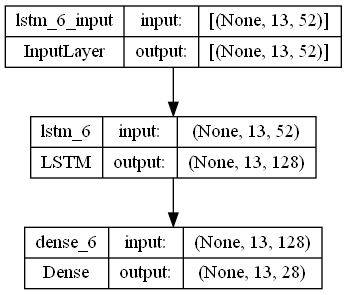

In [164]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [195]:

def make_name(model, types=np.zeros((1, type_dim)), stats=np.array([[100, 100, 100, 100, 100, 100]])):
    name = []
    x = np.zeros((1, max_char, char_dim))
    print(x.shape)
    types = np.tile(types, (1, max_char, 1))
    print(types.shape)
    # # concatenatre types with x after char_dim
    x = np.concatenate((x, types), axis=2)
    # print(x.shape)
    # # concatenate stats at the end of x
    stats = np.tile(stats, (1, max_char, 1))
    print(stats.shape)
    x = np.concatenate((x, stats), axis=2)
    # # x = np.expand_dims(x, axis=2)
    # print(x.shape)
    
    end = False
    i = 0
    
    while end==False:
        probs = list(model.predict(x, verbose=0)[0,i])
        probs = probs / np.sum(probs)
        index = np.random.choice(range(char_dim), p=probs)
        if i == max_char-2:
            character = '.'
            end = True
        else:
            character = index_to_char[index]
        name.append(character)
        x[0, i+1, index] = 1
        i += 1
        if character == '.':
            end = True
    
    print(''.join(name))

In [168]:
def train(epoch, _):
    if epoch % 25 == 0:
        
        print('Names generated after epoch %d:' % epoch)

        for i in range(3):
            make_name(model)
        
        print()
      
name_generator = LambdaCallback(on_epoch_end = train)

model.fit(X, Y, batch_size=64, epochs=500, callbacks=[name_generator], verbose=0)

Names generated after epoch 0:
iwdrnr.
jyjcbccxo.
lferalirrg.

Names generated after epoch 25:
ltauakn.
evunz.
gforoqrcfn.

Names generated after epoch 50:
aregml.
i dsri.
rbojdor.

Names generated after epoch 75:
onmekokddr.
nxgbe l.
oilooikbe.

Names generated after epoch 100:
wolpet.
aaruklo.
vtiroux.

Names generated after epoch 125:
punsukr.
winolpnmmak.
teunzo.

Names generated after epoch 150:
nnkekku.
surohcerehe.
a.

Names generated after epoch 175:
jwlleisr.
lanwow.
oxararyo.

Names generated after epoch 200:
zetrorntolo.
rogoweosht.
tattau.

Names generated after epoch 225:
legaskknb.
locai.
 gennio.

Names generated after epoch 250:
megtokn.
rebith.
.

Names generated after epoch 275:
ewvta.
xlarrsu.
indhamk.

Names generated after epoch 300:
edicnwphbln.
argutwrre.
woslirul.

Names generated after epoch 325:
jenps.
jxlrl.
olcowe.

Names generated after epoch 350:
hendo.
pinu.
xemie.

Names generated after epoch 375:
topaery.
yenuebd.
bersen.

Names generated after epoch 40

In [205]:
make_name(model, types=np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

(1, 13, 28)
(1, 13, 18)
(1, 13, 6)
tyjagaangaa.


In [206]:
model.save('name_gen_type_stat.h5')